# Apply new offsets to historical data and review residuals

In [1]:
import os
os.environ['SKA'] = '/Users/jean/ska'
import sys
sys.path.insert(0, '/Users/jean/git/chandra_aca')

In [2]:
from pathlib import Path
import astropy.units as u
from astropy.table import Table
from cheta import fetch_sci as fetch

import ska_dbi
from cxotime import CxoTime
from ska_matplotlib import plot_cxctime
import matplotlib.pyplot as plt
import numpy as np


In [3]:
import fid_drift_mon.plot_command_vs_telem
from fid_drift_mon.plot_command_vs_telem import (get_fids_telem, get_fids_commands,
                                                 get_dwells_with_fids, join_commands_telem)

/Users/jean/miniconda3/envs/ska3/lib/python3.10/site-packages/setuptools_scm/git.py:295: UserWarning: git archive did not support describe output
  warnings.warn("git archive did not support describe output")


In [4]:

def FID_STATS_PATH(data_dir):
    return Path(data_dir) / "fid_stats.db3"

In [5]:
start = CxoTime('2001:001')
stop = CxoTime.now()

In [6]:
fid_drift_mon.plot_command_vs_telem.logger.setLevel('ERROR')

In [7]:
fid_data_file = 'fid_commands_telem.dat'

In [8]:

if not Path(fid_data_file).exists():
    dwells = get_dwells_with_fids(start.date, stop.date);
    fids_commands = get_fids_commands(dwells);
    with ska_dbi.DBI(dbi='sqlite', server=FID_STATS_PATH('.')) as db:
        fids_telem = get_fids_telem(dwells, fids_commands, db)
    commands_telem = join_commands_telem(fids_commands, fids_telem)
    commands_telem.write(fid_data_file, format='ascii')
else:
    commands_telem = Table.read(fid_data_file, format='ascii')

In [9]:
import proseco.fid
# Use group_by to loop over the observations in the set to get all of the expected fid positions
obsids = commands_telem.group_by('obsid')
expected_pos = []
for obsid in obsids.groups:
    row = obsid[0]
    obs_ys, obs_zs = proseco.fid.get_fid_positions(detector=row['detector'],
                                                   focus_offset=row['focus_offset'],
                                                   sim_offset=row['sim_offset'])
    for row in obsid:
        if row['id'] == -999:
            continue
        expected_pos.append({'obsid': row['obsid'],
                             'id': row['id'],
                             'exp_pos_y': obs_ys[row['id'] - 1],
                             'exp_pos_z': obs_zs[row['id'] - 1]})


In [10]:
expected_pos = Table(expected_pos)

In [11]:
# Join expected_pos and commands_telem
import astropy.table
combined = astropy.table.join(expected_pos, commands_telem, keys=['obsid', 'id'])
commands_telem = combined

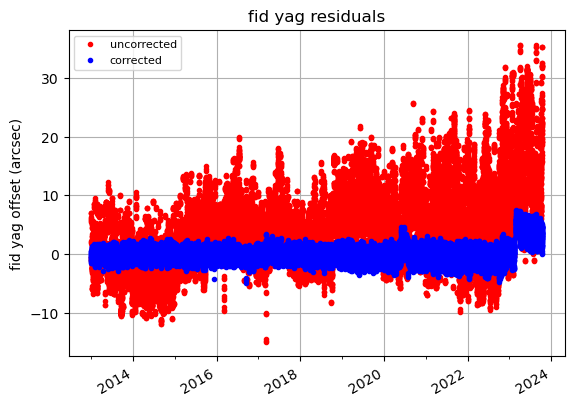

In [14]:
# Make a plot of y fid residuals
commands_telem.sort('tstart')
ok = commands_telem['tstart'] > CxoTime('2013:001').secs
tstart = commands_telem['tstart'][ok]
dat = fetch.Msid('AACCCDPT', tstart[0], tstart[-1], stat='5min')
t_ccd = np.interp(tstart, dat.times, dat.vals)
from chandra_aca.drift import get_fid_offset
dy, dz = get_fid_offset(tstart, t_ccd)

plot_cxctime(tstart, (commands_telem['aoacyan'][ok] - commands_telem['yang'][ok]), 'r.',
             label='uncorrected')
plot_cxctime(tstart,
            commands_telem['aoacyan'][ok] - (commands_telem['exp_pos_y'][ok] + dy),
            'b.', label='corrected')
plt.legend(fontsize=8)
plt.title('fid yag residuals')
plt.ylabel('fid yag offset (arcsec)')
plt.grid();

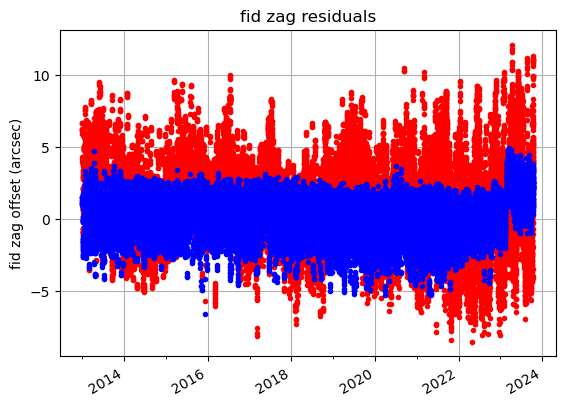

In [16]:
# Make a plot of z fid residuals
ok = commands_telem['tstart'] > CxoTime('2013:001').secs
tstart = commands_telem['tstart'][ok]
dat = fetch.Msid('AACCCDPT', tstart[0], tstart[-1], stat='5min')
t_ccd = np.interp(tstart, dat.times, dat.vals)
from chandra_aca.drift import get_fid_offset
dy, dz = get_fid_offset(tstart, t_ccd)
plot_cxctime(tstart, (commands_telem['aoaczan'][ok] - commands_telem['zang'][ok]), 'r.')
plot_cxctime(tstart,
            commands_telem['aoaczan'][ok] - (commands_telem['exp_pos_z'][ok] + dz),
            'b.')

plt.title('fid zag residuals')
plt.ylabel('fid zag offset (arcsec)')
plt.grid();